# Neural Language Model: A Start


- In this tutorial, we will look at a naive example of **neural language model**.
- Given a corpus, we can build a neural language model, which will learn to predict the next word given a specified limited context.

- Depending on the size of the **limited context**, we can implement different types of neural language model:
    - **Bigram**-based neural language model: The model uses one preceding word for the next-word prediction.
    - **Trigram**-based neural language model: The model uses two preceding words for the next-word prediction.
    - **Line**-based neural language model: The model uses all the existing fore-going words in the "sequence" for the next-word prediction.
    - **Discourse**-based neural language model: The model uses inter-sentential information for next-word prediction (e.g., BERT).

- This tutorial will demonstarte how to build a bigram-based language model.
- In the Assignments, you need to extend the same rationale to other types of language models.

## Workflow of Neural Language Model

![](../images/neural-language-model-flowchart.png)

:::{seealso}
:class: dropdown

We frequently encounter the need to train models on large datasets, which can be memory-intensive and difficult to load entirely into the local machine's memory at once. Therefore, it's essential to master techniques for optimizing the data loading process during model training.

Tensorflow provides an effective Dataset API for this. Using TensorFlow Dataset API involves several steps to create and manipulate datasets efficiently. Here's a step-by-step guide:

1. **Import TensorFlow:**
   Make sure you have TensorFlow installed and import it into your Python script or notebook.

   ```python
   import tensorflow as tf
   ```

2. **Create Dataset from Data:**
   There are different ways to create a dataset, such as from a list, NumPy array, tensors, or files.

   ```python
   # From a list
   dataset = tf.data.Dataset.from_tensor_slices([1, 2, 3, 4, 5])

   # From a NumPy array
   import numpy as np
   arr = np.array([1, 2, 3, 4, 5])
   dataset = tf.data.Dataset.from_tensor_slices(arr)

   # From tensors
   tensor1 = tf.constant([1, 2, 3])
   tensor2 = tf.constant([4, 5, 6])
   dataset = tf.data.Dataset.from_tensors((tensor1, tensor2))

   # From files
   file_paths = ['file1.txt', 'file2.txt']
   dataset = tf.data.TextLineDataset(file_paths)
   ```

3. **Transformations:**
   Apply transformations to the dataset using methods like `map()`, `filter()`, `batch()`, `shuffle()`, etc.

   ```python
   # Map a function to each element
   dataset = dataset.map(lambda x: x * 2)

   # Filter elements
   dataset = dataset.filter(lambda x: x > 0)

   # Batch elements
   batched_dataset = dataset.batch(32)

   # Shuffle elements
   shuffled_dataset = dataset.shuffle(buffer_size=1000)

   # Repeat dataset
   repeated_dataset = dataset.repeat(count=3)
   ```

4. **Iterate Over the Dataset:**
   Use a `for` loop or iterator to iterate over the dataset and process the elements.

   ```python
   for item in dataset:
       print(item)

   # If you need to batch the dataset first
   for batch in batched_dataset:
       print(batch)
   ```

5. **Use in Model Training:**
   Pass the dataset directly to the model's `fit()` method for training.

   ```python
   model.fit(dataset, epochs=10)
   ```

6. **Performance Optimization:**
   For better performance, consider using prefetching, caching, and parallelism.

   ```python
   dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
   dataset = dataset.cache()
   dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
   ```

7. **Handling Complex Data:**
   For more complex data processing, you can use `tf.py_function` to apply Python functions to each element of the dataset.

   ```python
   def my_function(x):
       # Your custom Python code here
       return x * 2

   dataset = dataset.map(lambda x: tf.py_function(my_function, [x], tf.int32))
   ```

These are the basic steps to use TensorFlow Dataset API effectively. Adjustments can be made based on the specific requirements of your project and the characteristics of your data.

:::

## Bigram Model

- A bigram-based language model assumes that the next word (to be predicted) depends only on one preceding word.

In [1]:
## Dependencies
import numpy as np
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding

### Tokenization

- A quick reminder of important parameters for `Tokenzier()`:
   - **`num_words`**: the maximum number of words to keep, based on word frequency. Only the most common `num_words-1` words will be kept.
   - **`filters`**: a string where each element is a character that will be filtered from the texts. The default includes all punctuations, plus tabs and line breaks (except for the `'` character).
   - **`lower`**: boolean. Whether to convert the texts to lowercase.
   - **`split`**: string. Separator for word splitting.
   - **`char_level`**: if True, every character will be treated as a token.
   - **`oov_token`**: if given, it will be added to `word_index` and used to replace out-of-vocabulary words during `text_to_sequence` calls

In [2]:
# source text
data = """ Jack and Jill went up the hill\n
		To fetch a pail of water\n
		Jack fell down and broke his crown\n
		And Jill came tumbling after\n """

data = [l.strip() for l in data.split('\n') if l != ""]

# integer encode text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data)

# now the data consists of a sequence of word index integers
encoded = tokenizer.texts_to_sequences(data)

# determine the vocabulary size
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)
print(tokenizer.word_index)

Vocabulary Size: 22
{'and': 1, 'jack': 2, 'jill': 3, 'went': 4, 'up': 5, 'the': 6, 'hill': 7, 'to': 8, 'fetch': 9, 'a': 10, 'pail': 11, 'of': 12, 'water': 13, 'fell': 14, 'down': 15, 'broke': 16, 'his': 17, 'crown': 18, 'came': 19, 'tumbling': 20, 'after': 21}


### Text-to-Sequences and Training-Testing Sets

- Principles for bigrams extraction
    - When we create bigrams as the input sequences for network training, we need to make sure that we do not include **unmeaningful** bigrams, such as bigrams spanning the text boundaries, or sentence boundaries.

In [3]:
# create bigrams sequences

## bigrams holder
sequences = list()


## Extract bigrams from each text
for e in encoded:
    for i in range(1, len(e)):
        sequence = e[i - 1:i + 1]
        sequences.append(sequence)
print('Total Sequences: %d' % len(sequences))
sequences = np.array(sequences)

Total Sequences: 21


In [4]:
sequences[:5]

array([[2, 1],
       [1, 3],
       [3, 4],
       [4, 5],
       [5, 6]])

- A sequence contains both our input and also output of the network.
- That is, for bigram-based LM, the first word is the input *X* and the second word is the expected output *y*.

In [5]:
# split into X and y elements
X, y = sequences[:, 0], sequences[:, 1]

In [6]:
print(sequences[:5])
print(X[:5])
print(y[:5])


[[2 1]
 [1 3]
 [3 4]
 [4 5]
 [5 6]]
[2 1 3 4 5]
[1 3 4 5 6]


### One-hot Representation of the Next-Word 

- Because the neural language model is going to be a multi-class classifier (for word prediction), we need to convert our `y` into one-hot encoding.

In [7]:
# one hot encode outputs
y = to_categorical(y, num_classes=vocab_size)

In [8]:
y.shape

(21, 22)

In [9]:
print(y[:5])

[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


### Define RNN Language Model

In [10]:
# define model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=16, input_length=1))
model.add(LSTM(64))  # LSTM Complexity
model.add(Dense(vocab_size, activation='softmax'))
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1, 16)             352       
                                                                 
 lstm (LSTM)                 (None, 64)                20736     
                                                                 
 dense (Dense)               (None, 22)                1430      
                                                                 
Total params: 22518 (87.96 KB)
Trainable params: 22518 (87.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [11]:
# compile network
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
# fit network
model.fit(X, y, epochs=500, verbose=2)

Epoch 1/500
1/1 - 1s - loss: 3.0912 - accuracy: 0.0000e+00 - 559ms/epoch - 559ms/step
Epoch 2/500
1/1 - 0s - loss: 3.0901 - accuracy: 0.0000e+00 - 2ms/epoch - 2ms/step
Epoch 3/500
1/1 - 0s - loss: 3.0890 - accuracy: 0.0000e+00 - 2ms/epoch - 2ms/step
Epoch 4/500
1/1 - 0s - loss: 3.0879 - accuracy: 0.0952 - 2ms/epoch - 2ms/step
Epoch 5/500
1/1 - 0s - loss: 3.0868 - accuracy: 0.0952 - 2ms/epoch - 2ms/step
Epoch 6/500
1/1 - 0s - loss: 3.0857 - accuracy: 0.1429 - 2ms/epoch - 2ms/step
Epoch 7/500
1/1 - 0s - loss: 3.0846 - accuracy: 0.2857 - 2ms/epoch - 2ms/step
Epoch 8/500
1/1 - 0s - loss: 3.0835 - accuracy: 0.3333 - 2ms/epoch - 2ms/step
Epoch 9/500
1/1 - 0s - loss: 3.0823 - accuracy: 0.4286 - 2ms/epoch - 2ms/step
Epoch 10/500
1/1 - 0s - loss: 3.0812 - accuracy: 0.4286 - 2ms/epoch - 2ms/step
Epoch 11/500
1/1 - 0s - loss: 3.0800 - accuracy: 0.3810 - 2ms/epoch - 2ms/step
Epoch 12/500
1/1 - 0s - loss: 3.0788 - accuracy: 0.3810 - 2ms/epoch - 2ms/step
Epoch 13/500
1/1 - 0s - loss: 3.0776 - accura

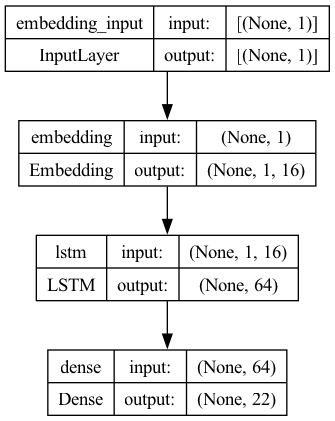

In [17]:
plot_model(model,  show_shapes= True)

### Text Generation Using the Model

- After we trained the bigram-based LM, we can use the model for text generation (e.g., a one-to-many sequence-to-sequence application).
- We can implement a simple text generator: the model always outputs the next-word that has the highest predicted probability value from the neural LM.
- At every time step, the model will use the newly predicted word as the input for another next-word prediction.

In [13]:
# generate a sequence from the model
def generate_seq(model, tokenizer, seed_text, n_words):
    in_text, result = seed_text, seed_text
    # generate a fixed number of words
    for _ in range(n_words):
        # encode the text as integer
        encoded = tokenizer.texts_to_sequences([in_text])[0]
        encoded = np.array(encoded)
        
        # predict a word in the vocabulary
        yhat=np.argmax(model.predict(encoded), axis=-1)
        
        # map predicted word index to word
        out_word = ''
        for word, index in tokenizer.word_index.items():
            if index == yhat:
                out_word = word
                break
        # append to input
        in_text, result = out_word, result + ' ' + out_word
    return result

- In the above `generate_seq()`, we use a **greedy search**, which selects the most likely word at each time step in the output sequence. 
- While this approach features its efficiency, the quality of the final output sequences may not necessarily be optimal.


In [14]:
# evaluate
print(generate_seq(model, tokenizer, 'Jill', 10))

1/1 [==============================] - 0s 8ms/step
Jill went up the hill and jill went up the hill


### Sampling Strategies for Text Generation

- Given a trained language model and a **seed** text chunk, we can generate new text by greedy-search like we've seen above.
- But we may sometimes have to add a certain degree of **variation** to the robotic texts for linguistic **creativity**.

- Possible alternatives:
    - We can re-normalize the predicted probability distributions of all next-words to reduce probability differences between the highest and the lowest. (Please see Ch.8.1 Text Generation with LSTM in Chollet's Deep Learning with Python. You will need this strategy for the assignment.)
    - We can use non-greedy search by keeping the top *k* probable candidates in the list for next-word prediction. (cf. **Beam Search** below) and determine the tokens by choosing the sequence of the maximum probability.

## Beam Search (skipped)

### Searching in NLP

- In the previous demonstration, when we generate the predicted next word, we adopt a naive approach, i.e., always choosing the word of the highest probability.
- It is common in NLP for models to output a probability distribution over words in the vocabulary.
- This step involves searching through all the possible output sequences based on their likelihood.
- Choosing the next word of highest probability does not guarantee us the most optimal sequence.
- The search problem is exponential in the length of the output sequence given the large size of vocabulary.


### Beam Search Decoding

The beam search expands all possible next steps and keeps the **$k$** most likely, where **$k$** is a researcher-specified parameter and controls the number of beams or parallel searches through the sequence of probabilities.

The search process can stop for each candidate independently either by:

- reaching a maximum length
- reaching an end-of-sequence token
- reaching a threshold likelihood

```{note]
Please see Jason Brownlee's blog post [How to Implement a Beam Search Decoder for Natural Language Processing](https://machinelearningmastery.com/beam-search-decoder-natural-language-processing/) for the python implementation.

The following codes are based on Jason's code.
```

:::{warning}
The following codes may not work properly. In Beam Search, when the model predicts `None` as the next character, we should set it as a stopping condition. The following codes have not be optimized with respect to this.
:::

In [15]:
# generate a sequence from the model
def generate_seq_beam(model, tokenizer, seed_text, n_words, k):
    in_text = seed_text 
    sequences = [[[in_text], 0.0]]
    # prepare id_2_word map
    id_2_word = dict([(i,w) for (w, i) in tokenizer.word_index.items()])
    
    # start next-word generating
    for _ in range(n_words):
        all_candidates = list()        
        #print("Next word ", _+1)
        # temp list to hold all possible candidates
        # `sequence + next words`


        # for each existing sequence
        # take the last word of the sequence
        # find probs of all words in the next position
        # save the top k
        # all_candidates should have 3 * 22 = 66 candidates
        
        for i in range(len(sequences)):
            # for the current sequence
            seq, score = sequences[i]            
            # next word probablity distribution
            encoded = tokenizer.texts_to_sequences([seq[-1]])[0]
            encoded = np.array(encoded)
            model_pred_prob = model.predict(encoded).flatten()

            # compute all probabilities for `curent_sequence + all_possible_next_word`
            for j in range(len(model_pred_prob)):
                candidate = [seq + [id_2_word.get(j+1)], score-np.log(model_pred_prob[j])]
                all_candidates.append(candidate)

            all_candidates= [[seq, score] for seq, score in all_candidates if seq[-1] is not None]

            # order all candidates (seqence + nextword) by score
            #print("all_condidates length:", len(all_candidates))
            ordered = sorted(all_candidates, key = lambda x:x[1]) # default ascending
            # select k best
            sequences = ordered[:k] ## choose top k

    return sequences

In [16]:
generate_seq_beam(model, tokenizer, 'Jill', 5, k =10)

1/1 [==============================] - 0s 7ms/step


[[['Jill', 'up', 'hill', 'jack', 'jack', 'jack'], 4.68290707655251],
 [['Jill', 'up', 'hill', 'jack', 'jack', 'down'], 4.72132352180779],
 [['Jill', 'up', 'hill', 'jack', 'jack', 'down', 'jack'], 4.762729896232486],
 [['Jill', 'up', 'hill', 'jack', 'jack', 'down', 'jack', 'jack'],
  5.449550641700625],
 [['Jill', 'up', 'hill', 'jack', 'jack', 'down', 'jack', 'down'],
  5.487967086955905],
 [['Jill', 'up', 'hill', 'jack', 'jack', 'down', 'jack', 'down', 'jack'],
  5.529373461380601],
 [['Jill', 'up', 'hill', 'jack', 'jack', 'down', 'jack', 'jack', 'jack'],
  6.136371387168765],
 [['Jill', 'up', 'hill', 'jack', 'jack', 'down', 'jack', 'jack', 'down'],
  6.174787832424045],
 [['Jill',
   'up',
   'hill',
   'jack',
   'jack',
   'down',
   'jack',
   'down',
   'jack',
   'jack'],
  6.216194206848741],
 [['Jill',
   'up',
   'hill',
   'jack',
   'jack',
   'down',
   'jack',
   'jack',
   'down',
   'jack'],
  6.216194206848741]]

## References

- Check [Ch 7 Neural Networks and Neural Language Models](https://web.stanford.edu/~jurafsky/slp3/) in Speech and Language Processing (3rd ed. draft).
- Chollet (2017): Ch 8.1
- Check Jason Brownlee's blog post [How to Develop Word-Based Neural Language Models in Python with Keras](https://machinelearningmastery.com/develop-word-based-neural-language-models-python-keras/)